In [1]:
# % matplotlib notebook 
from IPython.display import IFrame, display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib          import rc 
from matplotlib          import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os.path as path
import wget
from scipy.stats import norm

In [2]:
def GetHisto(l,NChannels,h = 1):
    h = 1.
    bins = np.arange(1,NChannels+2*h,h)
    w = np.diff(bins)
    m = bins[:-1] + 0.5*w[0] # marcas de clase
    return l,m,w

In [3]:
!rm Data/*
file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/ObsExtraT.csv'
if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

File loaded


In [4]:
Df = pd.read_csv(Path_)
print(Df)

   NData  NBkg  NSignal1  NSignal2
0     10     9        10         3
1     20    17        15         6
2     10     5        10         3
3      6     6         4         1


In [23]:
n = np.array(Df.NData)
b = np.array(Df.NBkg)
s = np.array(Df.NSignal2)
NChannels = len(n)

In [24]:
HData,m,w = GetHisto(n,NChannels)
ErrorData = np.sqrt(HData)
HBkg,m,w = GetHisto(b,NChannels)
HSignal,m,w = GetHisto(s,NChannels)

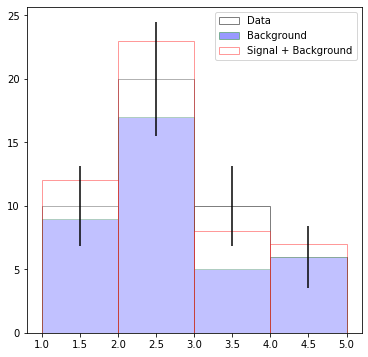

In [25]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.bar(m,HData,yerr=ErrorData, color='w', width=w, ec='k', label='Data', alpha=0.5)
ax.bar(m,HBkg, color='b' ,width=w, ec='g', label='Background', alpha=0.4)
ax.bar(m,HBkg+HSignal, color='w' ,width=w, ec='r', label='Signal + Background', alpha=0.4)
ax.legend(loc=0)

In [8]:
def GausLike( mu, sigma ):
    return np.exp( -0.5*(mu-1.0)**2/sigma**2 )/np.sqrt( 2*np.pi*sigma**2 )

In [9]:
def Likelihood(n,b,s,mu,e,lumi,sigmae=0.3,sigmal=0.2):
    
    if mu.any() < 0.:
        mu = 0.
    
    lambda_ = (mu*s+e*b)*lumi
    
    l = 1.
    l = np.exp(-lambda_)*(lambda_)**n / np.math.factorial(n) # Poisson
    l *= GausLike(e,sigmae) # resolucion experimental
    l *= GausLike(lumi,sigmal) 
    
    return l

In [10]:
def JointLikelihood(NChannels, Likelihood, mu, e, lumi, Type = 0 ):
    
    if Type == 0:
        l = 1.
        
        for c in range(NChannels):
            l *= Likelihood(n[c],b[c],s[c],mu,e,lumi)
            
    elif Type == 1:
        
        l = 0.
        
        for c in range(NChannels):
            l += -2*np.log( Likelihood(n[c],b[c],s[c],mu,e,lumi) )
            
    return l

In [11]:
mu = np.array([0.7])
L = JointLikelihood(NChannels, Likelihood, mu[0], 0.9, 1., Type = 1 )
print(L)

10.982369616076815


In [12]:
Npoints = 100
mu = np.linspace(0.01,2,Npoints)
ProfileLike0 = JointLikelihood(NChannels, Likelihood, mu, 0.96, 1., Type = 0 )
ProfileLike1 = JointLikelihood(NChannels, Likelihood, mu, 1., 1., Type = 1 )

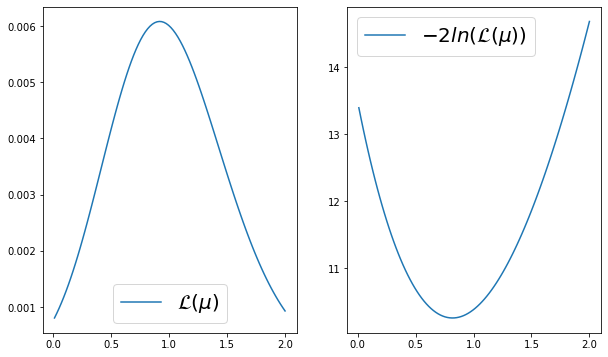

In [13]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(mu,ProfileLike0,label=r'$\mathcal{L}(\mu)$')
ax2.plot(mu,ProfileLike1,label=r'$-2ln(\mathcal{L}(\mu))$')
ax1.legend(loc=0, fontsize=20)
ax2.legend(loc=0, fontsize=20)

In [14]:
ii = np.where(ProfileLike0 == np.amax(ProfileLike0))
print(mu[ii])

[0.91454545]


In [15]:
Npoints = 100
mu = np.linspace(0.01,2,Npoints)
e = np.linspace(0.5,2,Npoints)
Mu, E = np.meshgrid(mu,e)
LikelihoodS =  JointLikelihood(NChannels, Likelihood, Mu, E, 1., Type = 1 )

In [16]:
# Calculando el minimo
ii = np.where(LikelihoodS == np.amin(LikelihoodS))
print(ii)
print(mu[ii[1]][0],e[ii[0]][0])

(array([31]), array([44]))
0.8944444444444445 0.9696969696969697


Text(0, 0.5, '$\\epsilon$')

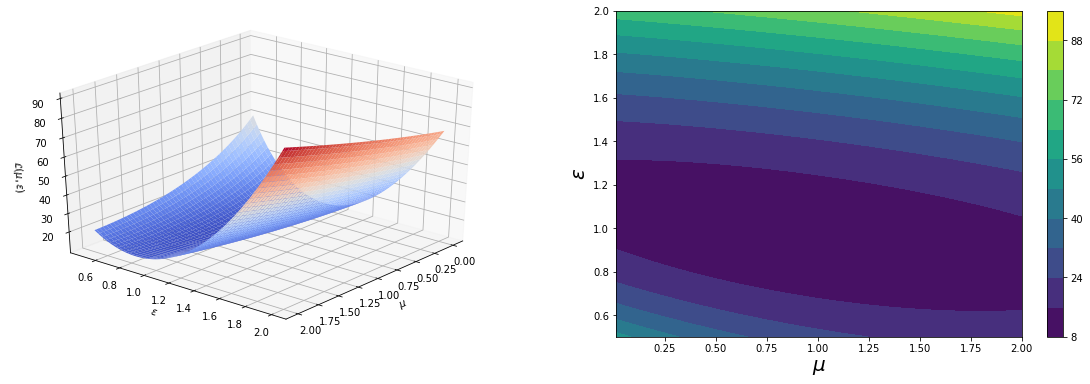

In [17]:
fig2 = plt.figure(figsize=(20,6))
ax1 = fig2.add_subplot(1,2,1, projection = '3d',elev = 30, azim = 40)
ax1.plot_surface(Mu, E, LikelihoodS,cmap=cm.coolwarm)
ax1.set_xlabel(r'$\mu$', fontsize=10)
ax1.set_ylabel(r'$\epsilon$', fontsize=10)
ax1.set_zlabel(r'$\mathcal{L}(\mu,\epsilon)$', fontsize=10)

ax2 = fig2.add_subplot(1,2,2)
c = ax2.contourf(Mu,E,LikelihoodS,10)
fig2.colorbar(c,ax=ax2)
ax2.set_xlabel(r'$\mu$', fontsize=20)
ax2.set_ylabel(r'$\epsilon$', fontsize=20)

In [18]:
def Metropolis( f,p, NSteps = int(1e5), delta = 0.1, burned = 20000):
    
    x = np.zeros( (NSteps, len(p)) )
    x[0] = np.array(p)
    
    for i in tqdm(range(1,NSteps)):
        
        
        present = f(NChannels,Likelihood,x[i-1,0],x[i-1,1],x[i-1,2],Type=0)
        
      
        x[i,:] = x[i-1,:] + (np.random.random(len(p))-0.5)*delta
      
     #   if x[i,0] < 0.:
     #       x[i,0] = - x[i,0]
    
        future = f(NChannels,Likelihood,x[i,0],x[i,1],x[i,2],Type=0)
        
        
        alpha = np.minimum(1.,future/present)
        
       
        g = np.random.rand()
        
        if g < alpha:
            x[i,:] = x[i,:]
        else:
            x[i,:] = x[i-1,:]
            
    ii = NSteps - burned
            
    return x[-ii:,:] 

In [19]:
p0 = np.array([1.0,1.0,1.0])
P = Metropolis( JointLikelihood, p0 )

100%|██████████| 99999/99999 [00:09<00:00, 10334.65it/s]


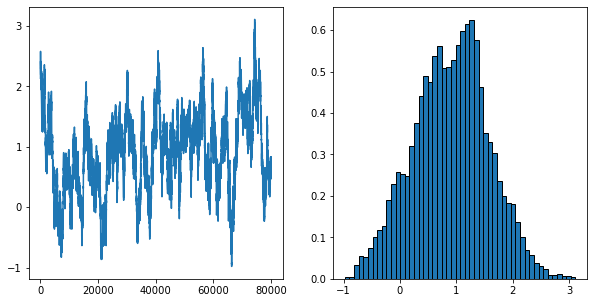

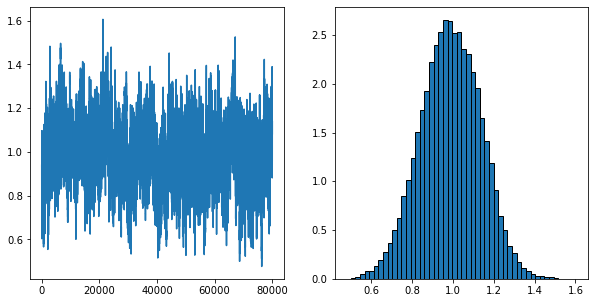

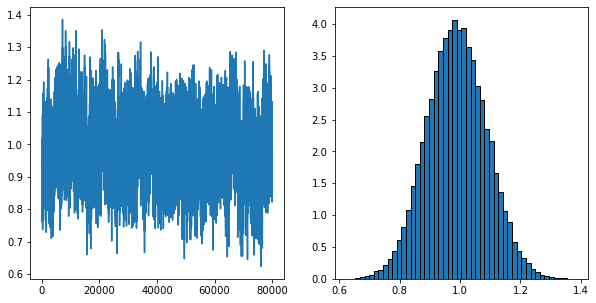

In [20]:
for i in range(len(P[0,:])):
    fig = plt.figure( figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(P[:,i])
    ax2.hist(P[:,i],  density=True, bins=50, ec='k')
    plt.show()

In [21]:
A = norm.cdf(1) # Area a 1 sigma
p = (1-A)/2
print(p,1-p)

0.07932762696572854 0.9206723730342714


In [22]:
mean = np.zeros(len(P[0,:]))
for i in range(len(P[0,:])):
    cuantiles = np.quantile(a=P[:,i], q=[p,1-p])
    mean[i] = np.percentile(P[:,i],50)
    print(mean[i],cuantiles)

0.9264379717865532 [-0.08587022  1.84065836]
0.9880782784590029 [0.77814078 1.19210523]
0.9875169290387329 [0.85078034 1.12845643]


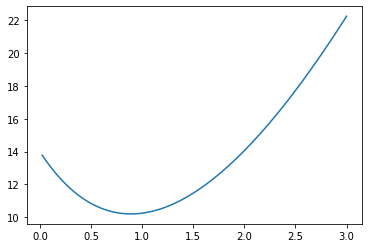

In [28]:
Npoints = 100
mu = np.linspace(0.02,3.0,Npoints)
ProfileLikelihood = JointLikelihood(NChannels,Likelihood,mu,mean[-1],mean[-2],Type=1)
plt.plot(mu,ProfileLikelihood)

In [29]:
ii = np.where( ProfileLikelihood == np.amin(ProfileLikelihood) )
muhat = mu[ii]
print(muhat)

[0.89292929]


In [30]:
min_ = JointLikelihood(NChannels,Likelihood,muhat,mean[-1],mean[-2],Type=1)
print(min_)

[10.2039513]


In [31]:
sigma3 = min_ + norm.ppf(0.95)**2
print(sigma3)

[12.90949476]


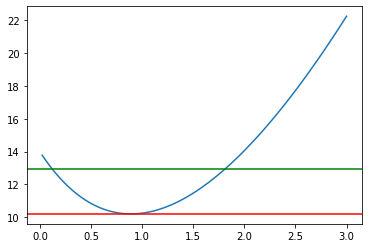

In [32]:
plt.plot(mu,ProfileLikelihood)
plt.axhline(y = min_, color='r')
plt.axhline(y = sigma3, color='g')

In [37]:
lista = []
mu = np.linspace(0.5,3.0,1000)
for m in mu:
    l = JointLikelihood(NChannels,Likelihood,m,mean[-1],mean[-2],Type=1)
    if np.abs(l-sigma3) < 0.01:
        print(l,m)
        lista.append(m)

12.903200587093455 1.8038038038038038
12.916857208431733 1.8063063063063063


$$ \mu^{up} = S^{up}/S $$ 